# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:

- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [ ]:
!pip install -U scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
#import shap
#import phik
import scipy.stats as st
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
from math import sqrt
#from scipy import stats
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression #, LogisticRegression #, Ridge
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler #, LabelEncoder, OneHotEncoder, OrdinalEncoder
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline #, make_pipeline
from sklearn.compose import ColumnTransformer #, make_column_transformer
from sklearn.impute import SimpleImputer
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor #, DecisionTreeClassifier

In [ ]:
sklearn.__version__

'1.4.0'

In [ ]:
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('C:/Users/Student/Desktop/geo_data_0.csv')
    geo_data_1 = pd.read_csv('C:/Users/Student/Desktop/geo_data_1.csv')
    geo_data_2 = pd.read_csv('C:/Users/Student/Desktop/geo_data_2.csv')

In [ ]:
def dfinfo(df):
    df.info()
    display(df.head())
    print('Пропуски:')
    print(df.isna().sum())
    print('Дубликатов', df.duplicated().sum())

dfinfo(geo_data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Пропуски:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Дубликатов 0


In [ ]:
dfinfo(geo_data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Пропуски:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Дубликатов 0


In [ ]:
dfinfo(geo_data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Пропуски:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Дубликатов 0


Во всех 3 датасетах по регионам по 100 000 строк, нет пропусков и явных дубликатов.

In [ ]:
for i in range(0,3):
    geo = globals()['geo_data_'+str(i)]
    geo_id = geo['id'].value_counts()
    geo_id = geo_id[geo_id>1]
    print('geo_data_'+str(i))
    print(geo.query('id in @geo_id.index').sort_values(by='id'))
    print()

geo_data_0
          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.

У нас есть скважины, повторяющиеся по 2 раза, но с разными признаками (не явные дубликаты). Пока непонятно, нужно ли их удалять. Среди 100 тыс. строк они капля в море.

In [ ]:
def issl_analiz(df, x, list_col = []):
    display(df.describe())

    if list_col == []:
        list_col = df.select_dtypes(exclude='object').columns
    if len(list_col)>1:
        fig,axes = plt.subplots(nrows=len(list_col), ncols=2, figsize=(15, x))
        i=0
        for col in list_col:
            df[col].plot(kind='hist', x=col, ax=axes[i][0], title=col, bins=50, label=col, legend=True).set(
                ylabel='количество', xlabel=col)
            sns.boxplot(x=col, data=df, ax=axes[i][1]).set(title=col)
            i+=1
    else:
        fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, x))
        for col in list_col:
            df[col].plot(kind='hist', x=col, ax=axes[0], title=col, bins=50, label=col, legend=True).set(
                ylabel='количество', xlabel=col)
            sns.boxplot(x=col, data=df, ax=axes[1]).set(title=col)

    plt.show()

Распределение количественных признаков geo_data_0:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


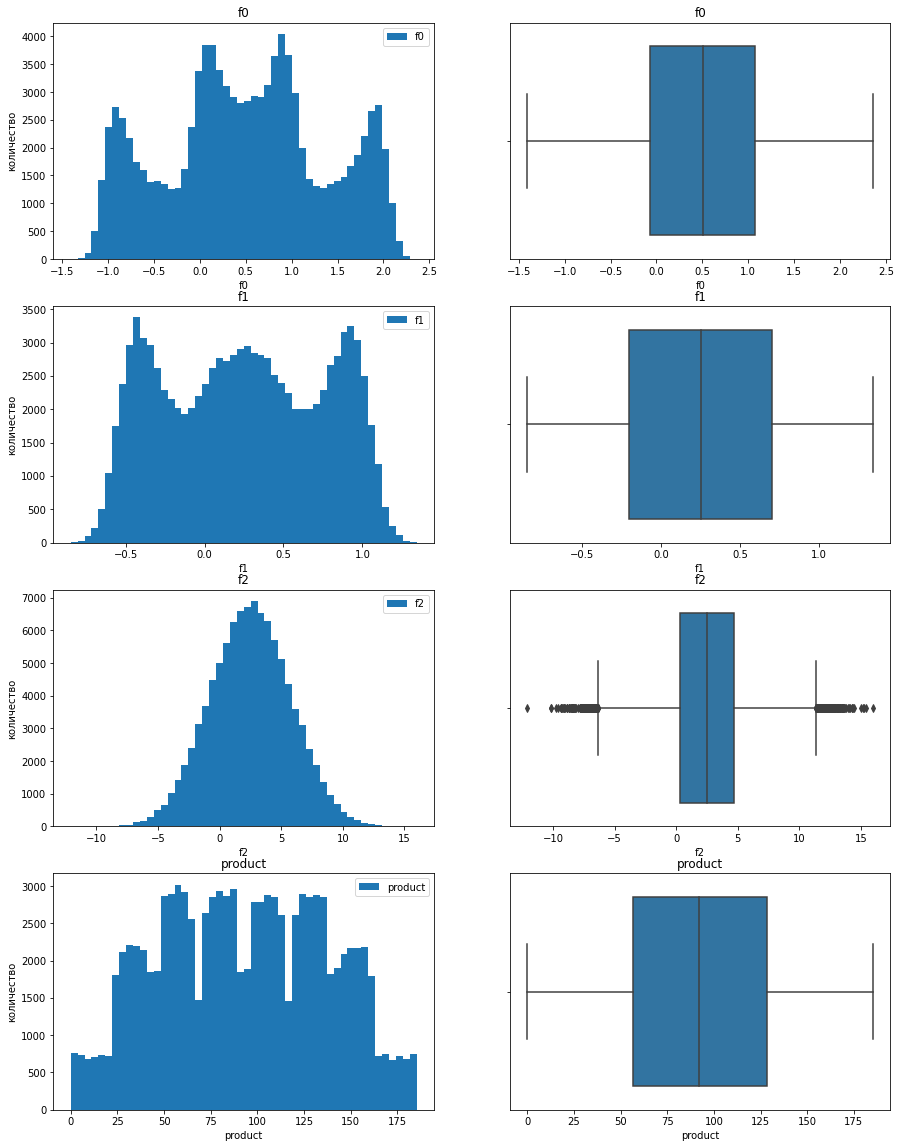

Распределение количественных признаков geo_data_1:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


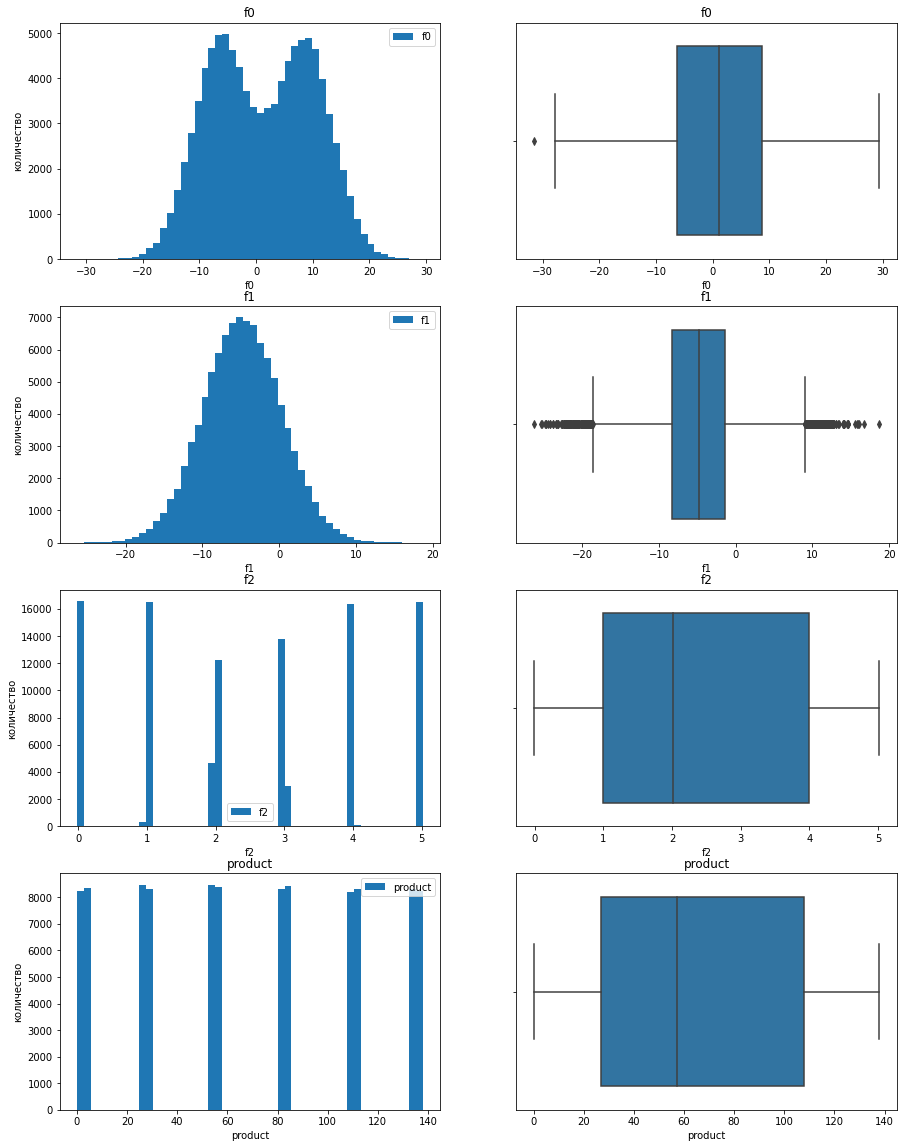

Распределение количественных признаков geo_data_2:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


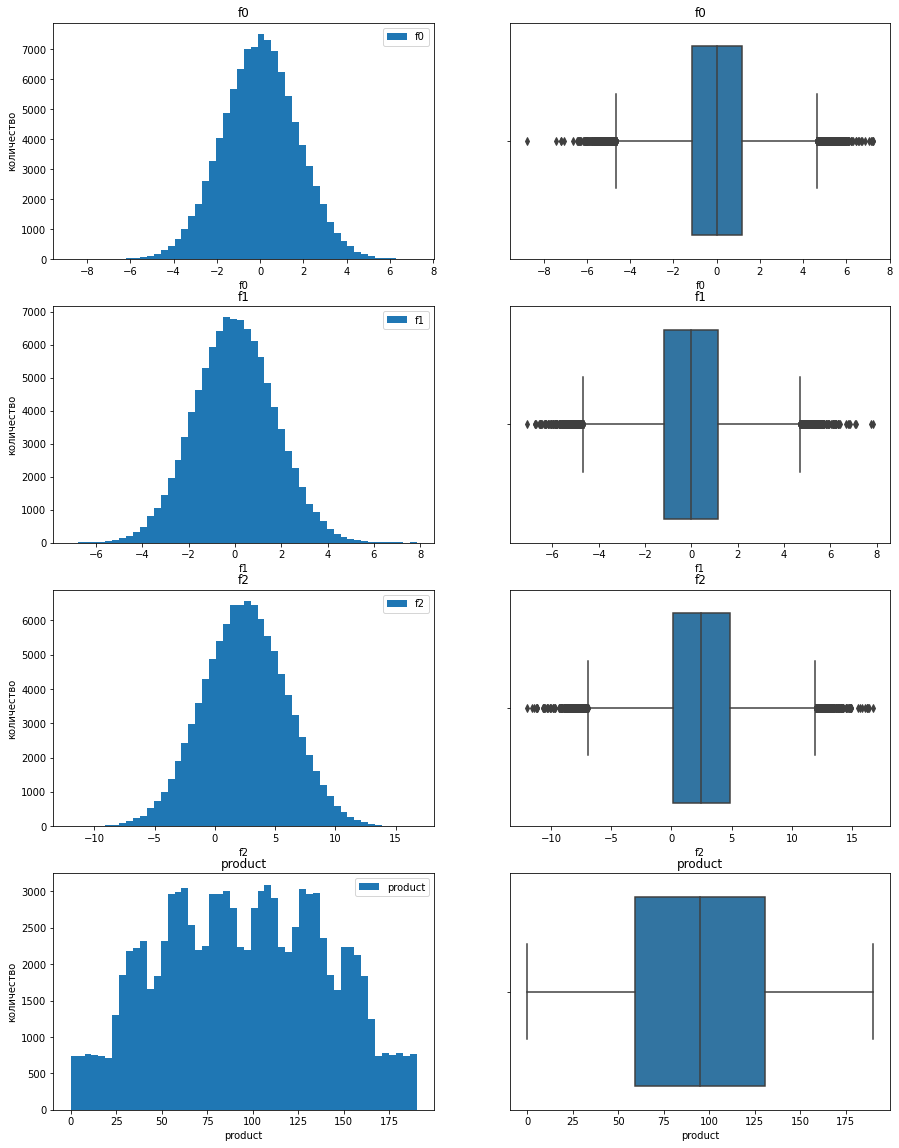

In [ ]:
for i in range(0,3):
    geo = globals()['geo_data_'+str(i)]
    print('Распределение количественных признаков geo_data_'+str(i)+':')
    issl_analiz(geo, 20)

В регионе 0 нормально распределён только признак f2, распределение f0 имеет 4 пика, f1 3 пика, product распределён с провалами.

В регионе 1 нормально распределён признак f1, распределение f0 имеет 2 пика, f2 и product имеют мало уникальных значений (product в каждой группе примерно одинаковое количество наблюдений, f2 с провалом посередине на значениях около 2 и около 3).

В регионе 2 признаки f0-f2 нормально распределены, product распределён с провалами.

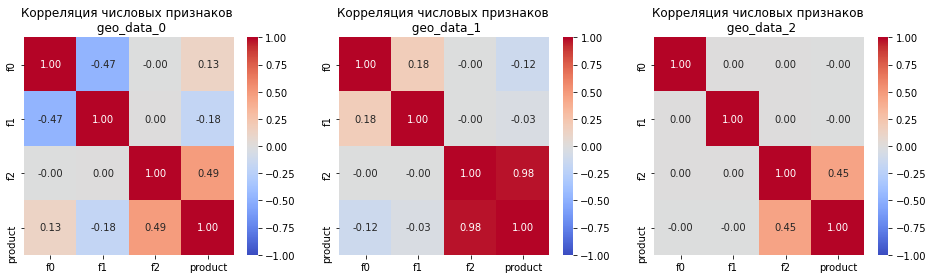

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(0,3):
    geo = globals()['geo_data_'+str(i)]
    sns.heatmap(geo.corr(method='spearman'), annot=True, cmap='coolwarm', vmin=-1, fmt='.2f', ax=axes[i]).set(
        title='Корреляция числовых признаков \n geo_data_'+str(i))

plt.show()

В регионе 1 признак f2 имеет мультиколлинеарность с целевым признаком product (объёмом запасов нефти в скважине).

В регионе 0 f0 и f1 имеют слабую отрицательную связь, в регионах 0 и 2 f2 и целевой признак - слабую положительную связь.

Остальные признаки не имеют связи или очень слабую.

Смысл входящих признаков нам неизвестен и их всего 3. Веских причин удалять какие-либо признаки нет (дальних выбросов нет, мультиколлениарности между входящими тоже нет).

## Обучение и проверка модели

### Разбейте данные на обучающую и валидационную выборки в соотношении 75:25

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

def tt_split (df):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE,
                                                        random_state = RANDOM_STATE)
    return X_train, X_test, y_train, y_test

###  Обучите модель и сделайте предсказания на валидационной выборке

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), ['f0', 'f1', 'f2'])
    ],
    remainder='passthrough') # verbose_feature_names_out=False)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


def geo_rmse_pred(df):
    X_train, X_test, y_train, y_test = tt_split(df)
    grid.fit(X_train, y_train)
    #print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
    print('Метрика RMSE на кросс-валидации:', round(-grid.best_score_, 4))
    y_pred = grid.best_estimator_.predict(X_test)
    print('Метрика RMSE на тестовой выборке:', round(mean_squared_error(y_test, y_pred, squared=False), 4))
    print('Cредний запас предсказанного сырья:', round(y_pred.mean(), 4), 'тыс. баррелей')
    return y_test, y_pred


###  Сохраните предсказания и правильные ответы на валидационной выборке

###  Напечатайте на экране средний запас предсказанного сырья и RMSE модели

In [ ]:
print('Линейная регрессия для geo_data_0:')
y_test_0, y_pred_0 = geo_rmse_pred(geo_data_0)

print()
print('Линейная регрессия для geo_data_1:')
y_test_1, y_pred_1 = geo_rmse_pred(geo_data_1)

print()
print('Линейная регрессия для geo_data_2:')
y_test_2, y_pred_2 = geo_rmse_pred(geo_data_2)

Линейная регрессия для geo_data_0:
Метрика RMSE на кросс-валидации: 37.672
Метрика RMSE на тестовой выборке: 37.7566
Cредний запас предсказанного сырья: 92.3988 тыс. баррелей

Линейная регрессия для geo_data_1:
Метрика RMSE на кросс-валидации: 0.8905
Метрика RMSE на тестовой выборке: 0.8903
Cредний запас предсказанного сырья: 68.7129 тыс. баррелей

Линейная регрессия для geo_data_2:
Метрика RMSE на кросс-валидации: 40.027
Метрика RMSE на тестовой выборке: 40.1459
Cредний запас предсказанного сырья: 94.771 тыс. баррелей


###  Проанализируйте результаты

Лучшая RMSE получилась в регионе 1 (датасет geo_data_1), но и запас сырья там меньше, чем в остальных регионах.

## Подготовка к расчёту прибыли

###  Все ключевые значения для расчётов сохраните в отдельных переменных

In [ ]:
budjet = 10
revenue_barr = 450
bests = 200

###  Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

In [ ]:
print('Бюджет на разработку скважин каждого региона, млрд. рублей:', budjet)
print('Доход с одной единицы продукта, т.е. с 1 тыс. баррелей, тыс. рублей:', revenue_barr)
product_geo_ok = budjet*1000000/revenue_barr
print('Для окупаемости бюджета в одном регионе нужно добыть не менее', round(product_geo_ok, 4), 'тыс. баррелей сырья')
print('Т.е. в среднем с одной скважины из 200 лучших нужно добыть не менее',round(product_geo_ok/bests, 4),'тыс.баррелей')

Бюджет на разработку скважин каждого региона, млрд. рублей: 10
Доход с одной единицы продукта, т.е. с 1 тыс. баррелей, тыс. рублей: 450
Для окупаемости бюджета в одном регионе нужно добыть не менее 22222.2222 тыс. баррелей сырья
Т.е. в среднем с одной скважины из 200 лучших нужно добыть не менее 111.1111 тыс.баррелей


Во всех трёх регионах средняя добыча с одной скважины меньше требуемого объёма для окупаемости затрат.

###  Напишите выводы по этапу подготовки расчёта прибыли

Во всех трёх регионах средняя добыча с одной скважины меньше требуемого объёма для окупаемости затрат, поэтому важно выбрать правильные 200 скважин, чтоб прибыль была не ниже 0.

## Расчёт прибыли и рисков - функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [ ]:
def geo_profit (df_zip):
    # Выберите скважины с максимальными значениями предсказаний
    df200 = df_zip.sort_values(by='pred', ascending=False).head(bests)

    # Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям
    product200 = df200['test'].sum() # тыс.баррелей

    # Рассчитайте прибыль для полученного объёма сырья
    profit200 = product200 * revenue_barr / 1000000 - budjet # млрд.рублей

    # проверка на попадание в 200 лучших дублей скважин
    #geo_id = df200['id'].value_counts()
    #geo_id = geo_id[geo_id>1]
    #display(df200.query('id in @geo_id.index').sort_values(by='id'))

    return profit200

In [ ]:
# вспомогательная функция для сборки id скважин, фактической добычи и предсказаний в 1 датафрейм
def geo_zip(df, y_test, y_pred):
    return pd.DataFrame(zip(y_test, y_pred), columns=['test','pred']).join(df['id'])

In [ ]:
geo_profit(geo_zip(geo_data_0, y_test_0, y_pred_0))

3.3591411144621794

In [ ]:
geo_profit(geo_zip(geo_data_1, y_test_1, y_pred_1))

2.415086696681513

In [ ]:
geo_profit(geo_zip(geo_data_2, y_test_2, y_pred_2))

2.598571759374112

На всякий случай проверила функцию на трёх регионах - везде положительная прибыль (но это на 200 лучших скважин из всех 25 тыс. известных тестовых, без бутстрепа).

## Расчёт прибыли и рисков для каждого региона - применение Bootstrap

###  Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [ ]:
def bootstrap(df_geo_zip):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        df_geo_zip_sub = df_geo_zip.sample(500, random_state=state, replace=True)
        values.append(geo_profit(df_geo_zip_sub))

    values = pd.Series(values)
    mean = values.mean()
    risk = len(values[values<0])/len(values)
    print('Средняя прибыль:', round(mean, 4), 'млрд.рублей')
    print('95%-й доверительный интервал:', round(values.quantile(0.025), 4), round(values.quantile(0.975), 4))
    print('Вероятность убытков:', round(risk*100, 4), '%')
    values.plot(kind='hist', title='Распределение прибыли', bins=50, label='прибыль', legend=True)
    plt.vlines(x=values.quantile(0.025), ymin=0, ymax=65, color='red', label='доверительный\nинтервал')
    plt.vlines(x=values.quantile(0.975), ymin=0, ymax=65, color='red')
    plt.legend()

###  Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков (убыток — это отрицательная прибыль)

Результаты Bootstrap для региона 0:
Средняя прибыль: 0.4063 млрд.рублей
95%-й доверительный интервал: -0.1177 0.9117
Вероятность убытков: 6.7 %


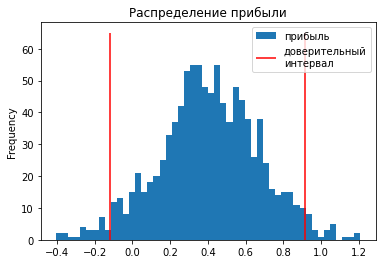

In [ ]:
print('Результаты Bootstrap для региона 0:')
bootstrap(geo_zip(geo_data_0, y_test_0, y_pred_0))

Результаты Bootstrap для региона 1:
Средняя прибыль: 0.4326 млрд.рублей
95%-й доверительный интервал: 0.0168 0.816
Вероятность убытков: 1.9 %


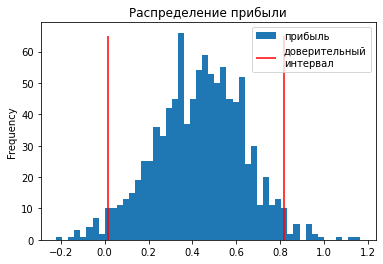

In [ ]:
print('Результаты Bootstrap для региона 1:')
bootstrap(geo_zip(geo_data_1, y_test_1, y_pred_1))

Результаты Bootstrap для региона 2:
Средняя прибыль: 0.3774 млрд.рублей
95%-й доверительный интервал: -0.1708 0.9018
Вероятность убытков: 7.4 %


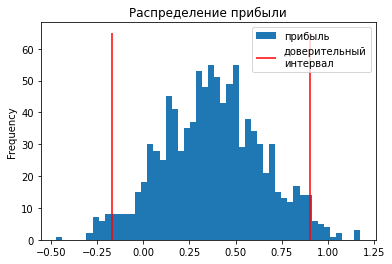

In [ ]:
print('Результаты Bootstrap для региона 2:')
bootstrap(geo_zip(geo_data_2, y_test_2, y_pred_2))

###  Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор

**Выводы:** только в регионе 1 (geo_data_1) вероятность убытков ниже 2.5%, поэтому **регион 1** предлагается для разработки новых скважин.

В нём же наибольшая средняя прибыль (и доверительный интервал начинается с положительного значения, в отличие от других регионов).